<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 2 - Fronteras no Lineales </H3>
<H4 align='center'> Integrantes: Pablo Aguirre, Rol: 201473555-3; Jorge Aliste, Rol: 201473538-3 </H4>
<hr style="height:2px;border:none"/>

## Pregunta 3: *Taxi Trip Duration*

El objetivo de esta pregunta es predecir la duración del viaje de un taxi en Nueva York. La métrica de evaluación será el RMSLE (*Root Mean Squared Logarithm Error*):

$$
E(y,\hat{y}) = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left( \log{(y_i +1)}- \log{(\hat{y}_i+1}) \right)^2}
$$

In [2]:
from geopy.distance import great_circle
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler,StandardScaler

from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import losses

D:\User\jalis\Anaconda3\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def rmsle(predicted,real):    
    suma=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        suma += np.power((p - r),2)
    return np.sqrt(suma/len(predicted))

> a) Cargue los datos de entrenamiento como *dataframes* de pandas. Describa las variables involucradas en el problema, explorando el tipo de datos de que se trata, el número de valores distinto. Grafique adecuadamente el valor a predecir con algún gráfico que resuma su comportamiento, e.g. un histograma, boxplot u otro.

In [4]:
import pandas as pd
df = pd.read_csv("train.csv")
print(df.info())
print(df.head())
output = df['trip_duration'].values
output

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
None
          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06

array([ 455,  663, 2124, ...,  764,  373,  198], dtype=int64)

Dentro del dataset se encuentran 9 variables y 3 datos que son de identificación. 
+ Id: string que correspende a la id que se le da al viaje, es para identificar y no sirve como variable.
+ vendor_id: entero que corresponde al código asociado a la empresa que ofrece el servicio.
+ pickup_datetime, dropoff_datetime: strings que permiten conocer el tiempo en que se tomó y dejó a los pasajeros. El tiempo puede influir debido al tráfico.
+ passenger_count: entero con la cantidad de pasajeros. Este podría influir debido a que un pasajero se baje antes.
+ pickup_longitude, pickup_latitude, dropoff_latitude, dropoff_latitude: variables tipo float que proporciona información de la ubicación en que se toma y deja al pasajero. El sector donde ocurre esto influye en los tiempos.
+ store_and_fwd_flag: tipo char que determina si los datos fueron guardados en el almacenamiento del vehículo o si fueron enviados inmediatamente. Este dato no debe influir en el tiempo.
+ trip_duration: variable entera que indica el tiempo en que demora en realizar el viaje. Esta sería la variable dependiente.

Ahora, para un mejor análisis se genera un boxplot de la variable trip_duration:

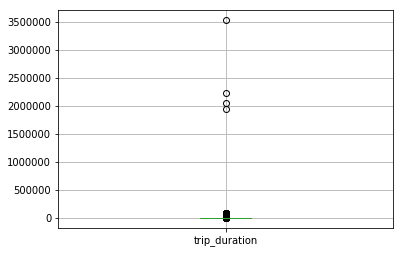

In [5]:
fig, ax = plt.subplots()

box = df.boxplot(ax=ax, column='trip_duration') 
plt.show()

El boxplot resultante indica que hay varios outliers que ni siquiera permiten ver bien el boxplot. Por lo que usando un histograma y acotando el rango se obtiene el siguiente histograma.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DC11956A58>]],
      dtype=object)

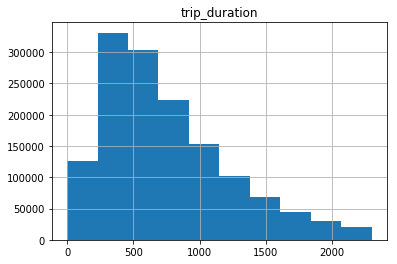

In [6]:
df.hist(column=['trip_duration'], range = (0,2300))

Con el histrograma se puede notar que la mayor cantidad de viajes toma un tiempo entre 250 y 750 segundos.

> b) Como puede  observar en los análisis preliminares exiten algunos *outliers* en los datos los cuales pensamos eliminar para que no entorpezca el aprendizaje, además que son muy pocos.

Para un mejor análisis, se eliminan los outliers. Como estos datos son muy distintos a los de la muestra, pueden afectar al entrenamiento de muy mala manera.

In [7]:
df = df[(df['trip_duration']<=1820)]

Se genera nuevamente el boxplot:

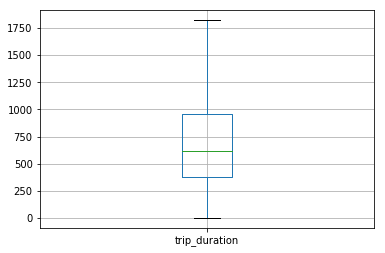

In [8]:
df.boxplot(column=['trip_duration'])

Ahora, se puede notar que la mediana se encuentra de los 500 segundos y como la caja se ve uniforme, podemos decir que la cantidad de datos se distribuye normalmente alrededor de la mediana.

> c) La primera operación que realizaremos a los datos como pre-procesamiento será la de extraer/generar características de manera manual de algunos atributos que resulta necesario hacer, como desde la fecha (string) puede ser extraída la hora del día, creando una nueva columna denominada *hour* y de tipo *int* discreto, o bien, para la localización del viaje punto a punto se pueden extraer distintas **medidas de distancia**. Comente sobre el pre-procesamiento realizado.  

In [9]:
"""extraer caract geograficas"""
def distance(p_lat,p_long,d_lat,d_long):
    pickup = (p_lat, p_long)
    dropoff = (d_lat, d_long)
    distance_all=great_circle(pickup, dropoff).km
    return distance_all
def grado(p_lat,p_long,d_lat,d_long):
    lat1= np.radians(p_lat)
    lat2= np.radians(d_lat)
    dLon = np.radians(d_long - p_long)
    y = np.sin(dLon)*np.cos(lat2)
    x = np.cos(lat1)*np.sin(lat2) - np.sin(lat1)*np.cos(lat2)*np.cos(dLon)
    return (np.degrees( np.arctan2(y,x) ) + 360 ) %360

cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2015',end='2017')
def preprocesar(df):
    df.fillna(0,inplace=True)
    """transformar fechas a tiempos"""
    df['hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['hour'] = pd.to_numeric(df['hour'])
    df['cday'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek #0:lunes,6:domingo
    df['cday'] = pd.to_numeric(df['cday'])
    df['month'] = pd.to_datetime(df['pickup_datetime']).dt.month #1:enero, 12: diciembre
    df['month'] = pd.to_numeric(df['month'])
    """Feature Generation"""
    df['distancia_viaje'] = np.sqrt( np.square(df['pickup_longitude']-df['dropoff_longitude']) 
                                    + np.square(df['pickup_latitude']-df['dropoff_latitude'])) #euclideana
    distancia_real_aprox = [ distance(df['pickup_latitude'].values[i], 
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    df['distancia_viaje_km'] = distancia_real_aprox
    df['grado_direccion'] = [ grado(df['pickup_latitude'].values[i],  #agregar direccion (en base a grado)
                                 df['pickup_longitude'].values[i],
                                 df['dropoff_latitude'].values[i],
                                 df['dropoff_longitude'].values[i]) for i in range(len(df['pickup_latitude']))]
    seasons = [0,0,1,1,1,2]  #0: winter, 1: spring, 2: summer
    df['season'] = [ seasons[df['month'].values[i] - 1] for i in range(len(df['month'])) ]  #agregar temporada
    df['holiday'] = df['pickup_datetime'].isin(holidays) #holidays
    """ Eliminar columnas -- limpiar"""
    df.drop(["pickup_datetime","dropoff_datetime","id","vendor_id","store_and_fwd_flag"], axis=1,inplace=True)
    df["holiday"] = df["holiday"].astype('category')#a categorico
    """codifica"""
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
preprocesar(df)
df.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,hour,cday,month,distancia_viaje,distancia_viaje_km,grado_direccion,season,holiday
0,1,-73.982155,40.767937,-73.964630,40.765602,455,17,0,3,0.017680,1.498523,99.970196,1,0
1,1,-73.980415,40.738564,-73.999481,40.731152,663,0,6,6,0.020456,1.805510,242.846232,2,0
3,1,-74.010040,40.719971,-74.012268,40.706718,429,19,2,4,0.013438,1.485501,187.262300,1,0
4,1,-73.973053,40.793209,-73.972923,40.782520,435,13,5,3,0.010690,1.188590,179.473585,1,0
5,6,-73.982857,40.742195,-73.992081,40.749184,443,22,5,1,0.011572,1.098944,315.004404,0,0


El objetivo del pre-procesamiento es generar nuevos atributos como combinaciones de otros pre-existentes. Esto puede servir ya que algunos atributos se potencian al estar en conjunto con otros.

> d) Cree las estructuras de los datos a utilizar, además de crear el conjunto de pruebas para validar los modelos ¿Cuáles son las dimensiones de cada conjunto? Normalice los datos, elija algún *scaler* y comente sobre su decisión.

In [10]:
# Corresponde a los valores de Y, la duración del viaje.
y = df['trip_duration'].values
# Se elimina la columna de la duración para obtener los valores de X.
df.drop("trip_duration",axis=1,inplace=True)
# Se obtiene la matriz de X.
X = df.values

# Se selecciona aleateriamente el conjunto de entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Se escalan los valores con robustscaler. 
scaler = RobustScaler(with_centering=True, with_scaling=True)

scaler.fit(X_train)

# Valores escalados.
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
print("Entrenamiento: ", X_train_scaled.shape)
print("Prueba: ", X_test_scaled.shape)

Entrenamiento:  (944181, 13)
Prueba:  (404650, 13)


El conjunto de entrenamiento cuenta con 941868 registros, mientras que el conjunto de prueba cuenta con 403658. Ambos con 13 atributos para cada registro.

Se elige `RobustScaler` ya que es más resistente a los outliers y podría favorecer la generalización por parte del modelo.

> e) En base a la definición del problema de esta sección y a lo experimentado en la sección 1, escoga un modelo de aprendizaje para experimentar en la predicción de la duración del viaje, comente sobre su decisión. Entrene el modelo escogido, usando parámetros por defecto, sobre la representación escalada generada anteriormente y mida el error de la competencia RMSLE sobre ambos conjuntos, comente.

Para este apartado, se decide experimentar con dos modelos: Red Neuronal Feed Forward y KNN. Se eligió RNFF debido a la gran cantidad de registros que se tienen para el input. Una red con muchas neuronas puede aprovechar esta cantidad más que una SVR. KNN se elige porque en la pregunta 1 demostró ser una muy buena solución para problemas no lineales, además de su simpleza en implementación. Para comparar estos dos modelos, se necesita un conjunto de validación, por lo que se determina que un 30% del conjunto de entrenamiento será de validación.

In [12]:
puntoDeCorte = X_train_scaled.shape[0]*0.7

X_train_scaled2 = X_train_scaled[:round(puntoDeCorte)]
X_val_scaled = X_train_scaled[round(puntoDeCorte):]

y_train2 = y_train[:round(puntoDeCorte)]
y_val = y_train[round(puntoDeCorte):]
print("Conjunto de entrenamiento:")
print(X_train_scaled2.shape)
print("Conjunto de validación:")
print(X_val_scaled.shape)

Conjunto de entrenamiento:
(660927, 13)
Conjunto de validación:
(283254, 13)


Primero se utiliza el modelo de Red Neuronal Feed Forward y se obtiene el error para RMSLE de entrenamiento y de validación:

In [12]:
modelNNR = Sequential()
modelNNR.add(Dense(512, input_dim=X_train_scaled2.shape[1], kernel_initializer='normal', activation="relu"))
modelNNR.add(Dropout(0.5))
modelNNR.add(Dense(256, kernel_initializer='normal', activation="relu"))
modelNNR.add(Dropout(0.5))
modelNNR.add(Dense(128, kernel_initializer='normal', activation="relu"))
modelNNR.add(Dropout(0.5))
modelNNR.add(Dense(64, kernel_initializer='normal', activation="relu"))
modelNNR.add(Dropout(0.5))
modelNNR.add(Dense(1, kernel_initializer='normal'))

modelNNR.compile(loss=losses.mean_squared_logarithmic_error, optimizer='RMSprop')

modelNNR.fit(X_train_scaled2, y_train2, epochs=10, batch_size=1024, verbose=1)

Epoch 1/10
660927/660927 [==============================] - 13s 20us/step - loss: 0.8922
Epoch 2/10
660927/660927 [==============================] - 12s 19us/step - loss: 0.2327
Epoch 3/10
660927/660927 [==============================] - 13s 20us/step - loss: 0.2197
Epoch 4/10
660927/660927 [==============================] - 13s 20us/step - loss: 0.2109
Epoch 5/10
660927/660927 [==============================] - 13s 20us/step - loss: 0.2061
Epoch 6/10
660927/660927 [==============================] - 13s 20us/step - loss: 0.2021
Epoch 7/10
660927/660927 [==============================] - 13s 20us/step - loss: 0.1991
Epoch 8/10
660927/660927 [==============================] - 13s 20us/step - loss: 0.1966
Epoch 9/10
660927/660927 [==============================] - 13s 20us/step - loss: 0.1945
Epoch 10/10
660927/660927 [==============================] - 13s 20us/step - loss: 0.1931


In [13]:
print("ERROR RMSLE de training: ", rmsle(modelNNR.predict(X_train_scaled2),y_train2))
print("ERROR RMSLE de val: ", rmsle(modelNNR.predict(X_val_scaled),y_val))

ERROR RMSLE de training:  [0.39232906]
ERROR RMSLE de val:  [0.39002917]


Mientras mas cercano a cero sea el RMSLE obtenido, mejor es el modelo. El error de entrenamiento y el de prueba son parecidos por lo que no se está produciendo overfitting.

Ahora, se prueba con el modelo de KNN, obteniendo los siguientes resultados:

In [14]:
from sklearn.neighbors import KNeighborsRegressor

print("Vecinos:", 7)
model = KNeighborsRegressor()
model.set_params(n_neighbors=7)
model.fit(X_train_scaled2, y_train2)
print ("ERROR RMSLE de training: ", rmsle(model.predict(X_train_scaled2),y_train2))
print ("ERROR RMSLE de val: ", rmsle(model.predict(X_val_scaled),y_val))

Vecinos: 7
ERROR RMSLE de training:  0.3648362642199857
ERROR RMSLE de val:  0.41059267062222904


En este caso el error de de entrenamiento es menor que en la red neuronal pero el error de validación es mayor, por lo que el modelo sufre de overfitting.

El resultado es que el modelo de red neuronal feed forward tiene un menor error de validación, por lo que es elegido para obtener el error del conjunto de prueba:

In [15]:
# Error de prueba
print ("ERROR RMSLE de test: ", rmsle(modelNNR.predict(X_test_scaled),y_test))

ERROR RMSLE de test:  [0.39168594]


El error no está tan alejado de 0, por lo que puede ser un modelo útil.

> f) Grafique las predicciones generadas por su modelo *vs* el valor real ¿Cuál es el comportamiento esperado? ¿Su resultado se asemeja a éste? ¿Por qué?

Se grafica primero para la predicción generada por redes neuronales:

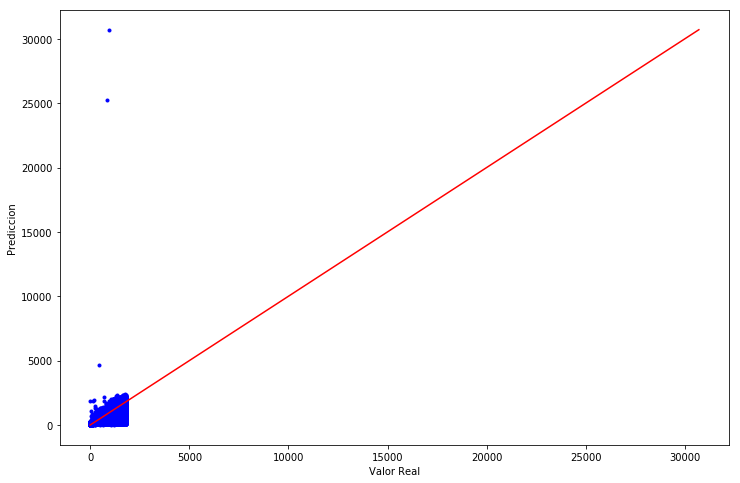

In [16]:
def graficar_predicciones(real,predecido, ymaxi = 0):
    plt.figure(figsize=(12,8))
    plt.plot(real,predecido,'b.')
    if ymaxi ==0:
        valor_max = int( np.max( [np.max(predecido),np.max(real)]))
    else:
        valor_max = ymaxi
        
    valor_min = int( np.min( [np.min(predecido),np.min(real)]))
    plt.plot(range(valor_min,valor_max+1), range(valor_min,valor_max+1), color ="r")
    plt.axis('tight')
    if ymaxi != 0:
        plt.ylim(ymax = ymaxi, ymin =0 )
    plt.xlabel('Valor Real')
    plt.ylabel('Prediccion')
    
    plt.show()
    
graficar_predicciones(y_test,modelNNR.predict(X_test_scaled))

El comportamiento esperado es que los puntos azules se ubiquen en la recta roja. Esto significa que el modelo es capaz de generalizar bien y la regresión es adecuada. 
En este caso los puntos azules están ubicados al comienzo de la recta roja, exceptuando algunos valores que se encuentran sobre la recta, por lo que la generalización no es mala. Para más detalle, se acota los valores posibles de Y.

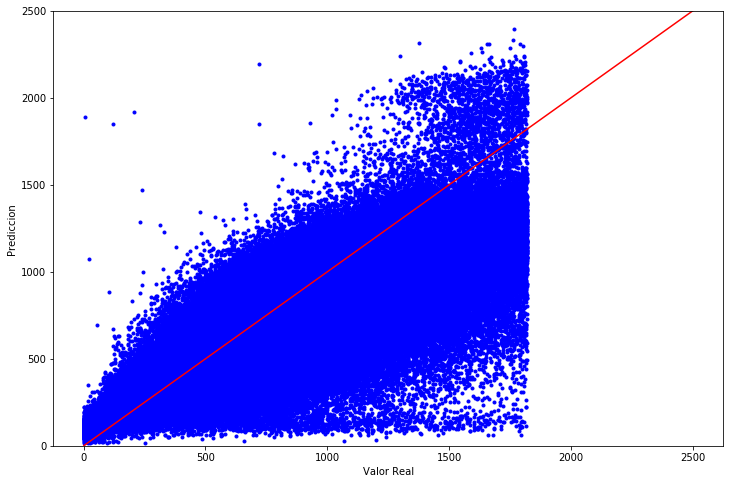

In [17]:
graficar_predicciones(y_test,modelNNR.predict(X_test_scaled), ymaxi = 2500)

Acá se puede ver más claramente el comportamiento. Muchos valores de la predicción se acercan al valor real pero igualmente hay varios que se alejan. Es importante notar que los puntos al parece siguen una tendencia de linea recta.

Ahora se realiza lo mismo pero para el método de knn:

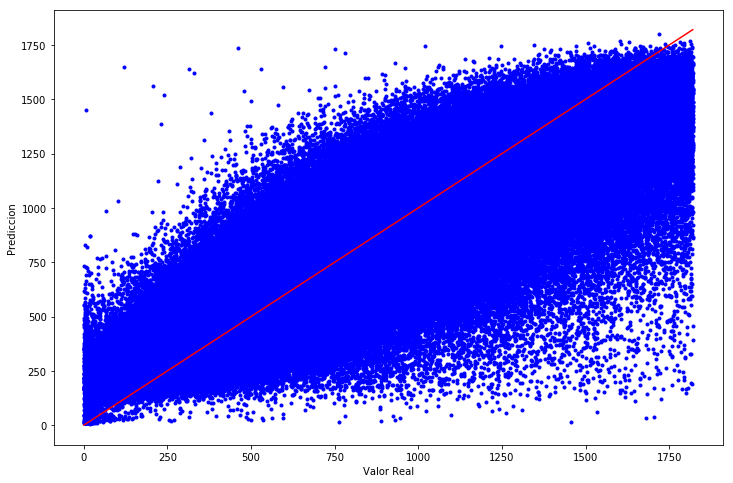

In [18]:
graficar_predicciones(y_test, model.predict(X_test_scaled))

En este podemos ver que knn presenta una mayor dispersión de los datos, lo que se condice con su mayor error. Notar también que mientras mayor el valor real, la predicción va perdiendo la recta.

> g) Mejore el desempeño del modelo de aprendizaje definido en e) haciendo modificaciones a los hiper-parámetros del modelo. Por ejemplo, tener ojo con el sobre-ajuste del modelo. Naturalmente, está absolutamente prohibido tomar este tipo de decisiones en función del resultado de pruebas. Debe realizar estas elecciones evaluando sobre el conjunto de validación. Si no desea utilizarlo, y prefiere implementar validación cruzada u otra técnica automática, tiene la ventaja de poder usar el conjunto de validación como parte del entrenamiento. 


Para el error de validación se decidió utilizar el conjunto de validación ya creado en la secciones anteriores ya que se tienen muchos datos y sería excesivo y costoso usar calidación cruzada. La proporción es 70% entrenamiento y 30% validación. Luego, se varían la cantidad de capas de la red neuronal:

In [19]:
modelNNR_2 = Sequential()
modelNNR_2.add(Dense(512, input_dim=13, kernel_initializer='normal', activation="relu"))
modelNNR_2.add(Dropout(0.5))
modelNNR_2.add(Dense(512, kernel_initializer='normal', activation="relu"))
modelNNR_2.add(Dropout(0.5))
modelNNR_2.add(Dense(256, kernel_initializer='normal', activation="relu"))
modelNNR_2.add(Dropout(0.5))
modelNNR_2.add(Dense(256, kernel_initializer='normal', activation="relu"))
modelNNR_2.add(Dropout(0.5))
modelNNR_2.add(Dense(128, kernel_initializer='normal', activation="relu"))
modelNNR_2.add(Dropout(0.5))
modelNNR_2.add(Dense(128, kernel_initializer='normal', activation="relu"))
modelNNR_2.add(Dropout(0.5))
modelNNR_2.add(Dense(1, kernel_initializer='normal'))

modelNNR_2.compile(loss=losses.mean_squared_logarithmic_error, optimizer='RMSprop')

modelNNR_2.fit(X_train_scaled2, y_train2, epochs=10, batch_size=512, verbose=1)

Epoch 1/10
660927/660927 [==============================] - 32s 49us/step - loss: 0.3735
Epoch 2/10
660927/660927 [==============================] - 34s 51us/step - loss: 0.2142
Epoch 3/10
660927/660927 [==============================] - 31s 47us/step - loss: 0.2007
Epoch 4/10
660927/660927 [==============================] - 31s 47us/step - loss: 0.1928
Epoch 5/10
660927/660927 [==============================] - 31s 48us/step - loss: 0.1883
Epoch 6/10
660927/660927 [==============================] - 31s 47us/step - loss: 0.1848
Epoch 7/10
660927/660927 [==============================] - 32s 49us/step - loss: 0.1820
Epoch 8/10
660927/660927 [==============================] - 30s 45us/step - loss: 0.1802
Epoch 9/10
660927/660927 [==============================] - 30s 46us/step - loss: 0.1781
Epoch 10/10
660927/660927 [==============================] - 32s 48us/step - loss: 0.1766


In [20]:
print("ERROR RMSLE de training: ", rmsle(modelNNR_2.predict(X_train_scaled2),y_train2))
print("ERROR RMSLE de validacion: ", rmsle(modelNNR_2.predict(X_val_scaled),y_val))

ERROR RMSLE de training:  [0.36800023]
ERROR RMSLE de validacion:  [0.36599795]


Se grafica la nueva predicción en función de los valores reales:

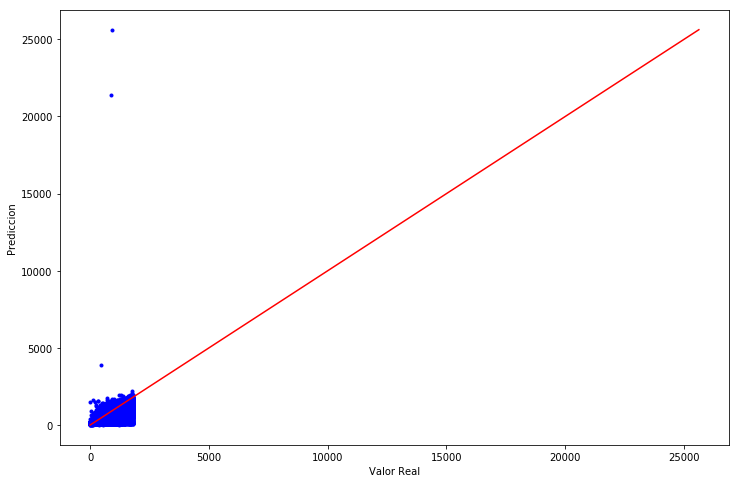

In [21]:
graficar_predicciones(y_test,modelNNR_2.predict(X_test_scaled))

Lo que respecta a redes neuronales, no se logró una mejora significativa respecto al modelo anterior por lo que la clave puede estar en una buena ingeniería de atributos.

Ahora, probando con knn junto la variación de otros parámetros se obtiene:

In [22]:
print("Vecinos:", 7)
model = KNeighborsRegressor()
model.set_params(n_neighbors=7, weights = "distance", algorithm= "auto", n_jobs = -1)
model.fit(X_train_scaled2, y_train2)
print ("ERROR RMSLE de training: ", rmsle(model.predict(X_train_scaled2),y_train2))
print ("ERROR RMSLE de val: ", rmsle(model.predict(X_val_scaled),y_val))

Vecinos: 7
ERROR RMSLE de training:  0.0034789635426418337
ERROR RMSLE de val:  0.4086860358515662


Con los nuevos parámetros, el error de entrenamiento se reduce bastante. El error de evaluación también se reduce pero la diferencia entre el error de entrenamiento y validación es considerable por lo que claramente existe overfitting en este modelo.

> h) Mejore el modelo de aprendizaje definido en el punto anterior, g), haciendo modificaciones sobre la representación utilizada para aprender desde los datos, es decir, *feature engineering* [[6]](#refs). Ya sea añadir nuevas características (puede inspirarse en los __[códigos](https://www.kaggle.com/c/nyc-taxi-trip-duration/kernels)__ de la gente en la competencia), como por ejemplo rescatar algo más de la fecha, como el año o los minutos, o algo de la ubicación y la distancia geográfica. También está la opción de utilizar lo visto en la tarea 1, de *feature selection* con FSS, *Mutual Information*, etc. Sea creativo, este paso le debiese reportar un salto de calidad muy significativo (RMSLE disminuir en 0.1 sobre el conjunto de pruebas).

Se agregan al dataset: velocidad, minutos y el año. Con esto se vuelve a probar los modelos.

In [13]:
dfPure = pd.read_csv("train.csv")
dfNew = df
dfNew['velocidad'] = df['distancia_viaje_km']/dfPure['trip_duration']
dfNew['year'] = pd.to_datetime(dfPure['pickup_datetime']).dt.year
dfNew['year'] = pd.to_numeric(dfNew['year'])
dfNew['minutes'] = pd.to_datetime(dfPure['pickup_datetime']).dt.minute
dfNew['minutes'] = pd.to_numeric(dfNew['minutes'])
dfNew.head()


,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,hour,cday,month,distancia_viaje,distancia_viaje_km,grado_direccion,season,holiday,velocidad,year,minutes
0,1,-73.982155,40.767937,-73.964630,40.765602,17,0,3,0.017680,1.498523,99.970196,1,0,0.003293,2016,24
1,1,-73.980415,40.738564,-73.999481,40.731152,0,6,6,0.020456,1.805510,242.846232,2,0,0.002723,2016,43
3,1,-74.010040,40.719971,-74.012268,40.706718,19,2,4,0.013438,1.485501,187.262300,1,0,0.003463,2016,32
4,1,-73.973053,40.793209,-73.972923,40.782520,13,5,3,0.010690,1.188590,179.473585,1,0,0.002732,2016,30
5,6,-73.982857,40.742195,-73.992081,40.749184,22,5,1,0.011572,1.098944,315.004404,0,0,0.002481,2016,1


In [14]:
# Corresponde a los valores de Y, la duración del viaje.
y3 = dfPure['trip_duration'].values

# Se obtiene la matriz de X.
X3 = dfNew.values

# Se selecciona aleateriamente el conjunto de entrenamiento y prueba.
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.3, random_state=42)

# Se escalan los valores con robustscaler. 
scaler = RobustScaler(with_centering=True, with_scaling=True)

scaler.fit(X_train3)

# Valores escalados.
X_train_scaled3 = scaler.transform(X_train3)
X_test_scaled3 = scaler.transform(X_test3)

puntoDeCorte2 = X_train_scaled3.shape[0]*0.7

X_train_scaled4 = X_train_scaled3[:round(puntoDeCorte2)]
X_val_scaled4 = X_train_scaled3[round(puntoDeCorte2):]

y_train4 = y_train3[:round(puntoDeCorte2)]
y_val4 = y_train3[round(puntoDeCorte2):]
print("Conjunto de entrenamiento:")
print(X_train_scaled4.shape)
print("Conjunto de validación:")
print(X_val_scaled4.shape)

Conjunto de entrenamiento:
(660927, 16)
Conjunto de validación:
(283254, 16)


In [25]:
modelNNR2 = Sequential()
modelNNR2.add(Dense(512, input_dim=X_train_scaled3.shape[1], kernel_initializer='normal', activation="relu"))
modelNNR2.add(Dropout(0.5))
modelNNR2.add(Dense(256, kernel_initializer='normal', activation="relu"))
modelNNR2.add(Dropout(0.5))
modelNNR2.add(Dense(128, kernel_initializer='normal', activation="relu"))
modelNNR2.add(Dropout(0.5))
modelNNR2.add(Dense(64, kernel_initializer='normal', activation="relu"))
modelNNR2.add(Dropout(0.5))
modelNNR2.add(Dense(1, kernel_initializer='normal'))

modelNNR2.compile(loss=losses.mean_squared_logarithmic_error, optimizer='RMSprop')

modelNNR2.fit(X_train_scaled3, y_train3, epochs=10, batch_size=1024, verbose=1)

Epoch 1/10
944181/944181 [==============================] - 19s 20us/step - loss: 0.5558
Epoch 2/10
944181/944181 [==============================] - 21s 22us/step - loss: 0.0783
Epoch 3/10
944181/944181 [==============================] - 20s 22us/step - loss: 0.0708
Epoch 4/10
944181/944181 [==============================] - 19s 20us/step - loss: 0.0686
Epoch 5/10
944181/944181 [==============================] - 21s 23us/step - loss: 0.0669
Epoch 6/10
944181/944181 [==============================] - 19s 20us/step - loss: 0.0656 0s - loss: 0.06
Epoch 7/10
944181/944181 [==============================] - 19s 20us/step - loss: 0.0645
Epoch 8/10
944181/944181 [==============================] - 20s 21us/step - loss: 0.0639
Epoch 9/10
944181/944181 [==============================] - 26s 28us/step - loss: 0.0627
Epoch 10/10
944181/944181 [==============================] - 21s 22us/step - loss: 0.0624


In [26]:
print ("ERROR RMSLE de training: ", rmsle(modelNNR2.predict(X_train_scaled3),y_train3))
print ("ERROR RMSLE de test: ", rmsle(modelNNR2.predict(X_test_scaled3),y_test3))

ERROR RMSLE de training:  [0.15709073]
ERROR RMSLE de test:  [0.15526999]


Al agregar estos nuevos parámetros podemos notar que el error se reduce considerablemente. Esto puede ser explicado porque la variable velocidad es un derivado del tiempo de viaje, por lo que tenemos un parámetro del cuál podemos obtener este tiempo.

In [27]:
print("Vecinos:", 50)
model = KNeighborsRegressor()
model.set_params(n_neighbors=50, weights = "distance", algorithm= "auto", n_jobs = -1)
model.fit(X_train_scaled3, y_train3)
print ("ERROR RMSLE de training: ", rmsle(model.predict(X_train_scaled3),y_train3))
print ("ERROR RMSLE de val: ", rmsle(model.predict(X_test_scaled3),y_test3))

Vecinos: 50
ERROR RMSLE de training:  0.0
ERROR RMSLE de val:  0.2872142517066163


Para un modelo de knn con peso a la distancia también se puede notar que le error bajó, de hecho es 0 en el entrenamiento pero lamentablemente el conjunto de prueba no es así. Existe un claro overfitting.

In [28]:
print("Vecinos:", 50)
model = KNeighborsRegressor()
model.set_params(n_neighbors=50, algorithm= "auto", n_jobs = -1)
model.fit(X_train_scaled3, y_train3)
print ("ERROR RMSLE de training: ", rmsle(model.predict(X_train_scaled3),y_train3))
print ("ERROR RMSLE de test: ", rmsle(model.predict(X_test_scaled3),y_test3))

Vecinos: 50
ERROR RMSLE de training:  0.28873289437888777
ERROR RMSLE de test:  0.2900744620151515


Para knn con 50 vecinos y una función de distancia estandar, el error se reduce en ambos conjuntos ya demás la diferencia entre ellos se reduce considerablemente. Esta configuración de parámetros no presenta overfitting.

> i) Ahora intente mejorar el modelo de aprendizaje definido en el punto anterior a través de alguna transformación al *output*. Por ejemplo, los histogramas que construyó en el punto a), ası́ como la forma especial de la función de evaluación, sugieren una cierta transformación de la variable respuesta (*output/target*). Una observación importante es que si hace una transformación a la variable respuesta (por ejemplo raı́z cuadrada), debe invertir esta transformación antes de evaluar el desempeño con la métrica de desempeño (por ejemplo, elevar al cuadrado si tomó raı́z cuadrada). Con ésto debería llegar a reducir el RMSLE a menos de 0.5.

No se pudo implementar.

1

> j) Evalúe el efecto de utilizar un ensamblado (combinación) de 2 máquinas de aprendizaje para predecir la duración de un viaje en taxi. Un modelo se especializará en la predicción de la duración de viajes de corta distancia, mientras que el otro modelo se enfocará en la predicción de la duración de viajes de larga distancia. Para la separación considere la media aritmética como el *split*. Hay razones claras para pensar que los patrones son distintos ¿Por qué? Puede mezclar distintos modelos de aprendizaje para cada subconjunto de dato de entrenamiento.

In [29]:
import pandas as pd
dafframe = pd.read_csv("train.csv")
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1348831 entries, 0 to 1458643
Data columns (total 16 columns):
passenger_count       1348831 non-null int64
pickup_longitude      1348831 non-null float64
pickup_latitude       1348831 non-null float64
dropoff_longitude     1348831 non-null float64
dropoff_latitude      1348831 non-null float64
hour                  1348831 non-null int64
cday                  1348831 non-null int64
month                 1348831 non-null int64
distancia_viaje       1348831 non-null float64
distancia_viaje_km    1348831 non-null float64
grado_direccion       1348831 non-null float64
season                1348831 non-null int64
holiday               1348831 non-null int8
velocidad             1348831 non-null float64
year                  1348831 non-null int64
minutes               1348831 non-null int64
dtypes: float64(8), int64(7), int8(1)
memory usage: 205.9 MB
None
   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0         